In [313]:
import glob
import contextlib
import os

import pandas as pd
import numpy as np

# Вспомогательные функции/классы

In [314]:
class DataParser:
    """
    Read file created by GRAL app (csv with header) and convert it to numpy ndarray
    """
    def __init__(self, filepath):
        self.__path = filepath
        print(filepath);
        self.__data = np.ndarray
        self.__header = {}
        self._file = None
        try:
            self._file = open(self.__path, "r")
        except OSError as er:
            print(f"Can't open file {er.filename}")
        self.__read_gral_output()

    def __read_gral_output(self):
        def __read_int_value(s: str, sep=' '):
            s = s.split(sep=sep)
            return int(s[-1])
        ncols    = __read_int_value(self._file.readline())
        nrows    = __read_int_value(self._file.readline())
        xmin     = __read_int_value(self._file.readline())
        ymin     = __read_int_value(self._file.readline())
        cellsize = __read_int_value(self._file.readline())
        self._file.readline() # to skip 6'th line
        self.__header = {
            "ncols": ncols,
            "nrows": nrows,
            "xmin": xmin,
            "ymin": ymin,
            "cellsize": cellsize
        }
        self.__data = np.flipud(np.genfromtxt(self._file, delimiter=' '))

    def get_data(self):
        return self.__data

    def get_header(self):
        return self.__header
    
    def get_all(self):
        return self.__data, self.__header

    def close(self):
        if self._file:
            self._file.close()
            self._file = None



In [315]:
def load_gral_names(dirname):
    output_names = glob.glob(f"./{dirname}/GRAL/*-*.txt")
    return output_names

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

def data_convert(dirname):
    datas = []
    header = {}
    output_names = load_gral_names(dirname)
    for filename in output_names:
        with contextlib.closing(DataParser(os.path.join(filename))) as file:
            header = file.get_header()
            data   = file.get_data()
            datas.append(data)
    xs = np.arange(header['xmin'], header['xmin'] + header['ncols'] * header['cellsize'], header['cellsize'])
    ys = np.arange(header['ymin'], header['ymin'] + header['nrows'] * header['cellsize'], header['cellsize'])
    
    cart = cartesian_product(ys, xs)
    values = np.sum(datas, axis=0)/len(datas)
    return pd.DataFrame.from_records([(c[0],c[1], value) for c,value in zip(cart, np.ravel(values))]), header


In [316]:
def drawGral(size: int = 1000):
    if size == 1000:
        dirpath = "1000x1000s100"
    
    data, header = data_convert(dirpath)
    data = data.sort_values([0, 1], ascending=[True, True])
    data.rename(columns={0: 'x', 1: 'y',2: 'value'}, inplace=True)
    print(data)
    print(header)
    
    from matplotlib import pyplot as plt
    def plot_tricontour(x, y, z, title, enable_levels=False):
        fig = plt.figure(figsize=(10,10))
        fig = plt.tricontour(x, y, z)
        
        plt.title(title)
        if enable_levels:
            fig = plt.clabel(fig, inline=1, fontsize=10)
        plt.savefig(title + ".svg", format='svg', dpi=1200)
        return fig
    p = plot_tricontour(data['y'], data['x'], data['value'], f"GRAL {size}x{size}", True)


## Сравнение расчетов Граль и ГОСТ №1

1. Размер поля 1000 на 1000 м
2. Шаг сетки 100 м
3. Среднее значение GRAL: 0.04111064757574843
4. Среднее значение GOST: 0.03755132231404957
5. Относительная ошибка: 0.09478561718629977

./1000x1000s100/GRAL\00001-101.txt
        x    y    value
0    -800   20  0.21207
1    -800   40  0.14286
2    -800   60  0.10252
3    -800   80  0.09524
4    -800  100  0.14613
...   ...  ...      ...
1857  -60  900  0.00000
1858  -60  920  0.00000
1859  -60  940  0.00000
1860  -60  960  0.00000
1861  -60  980  0.00000

[1862 rows x 3 columns]
{'ncols': 49, 'nrows': 38, 'xmin': 20, 'ymin': -800, 'cellsize': 20}


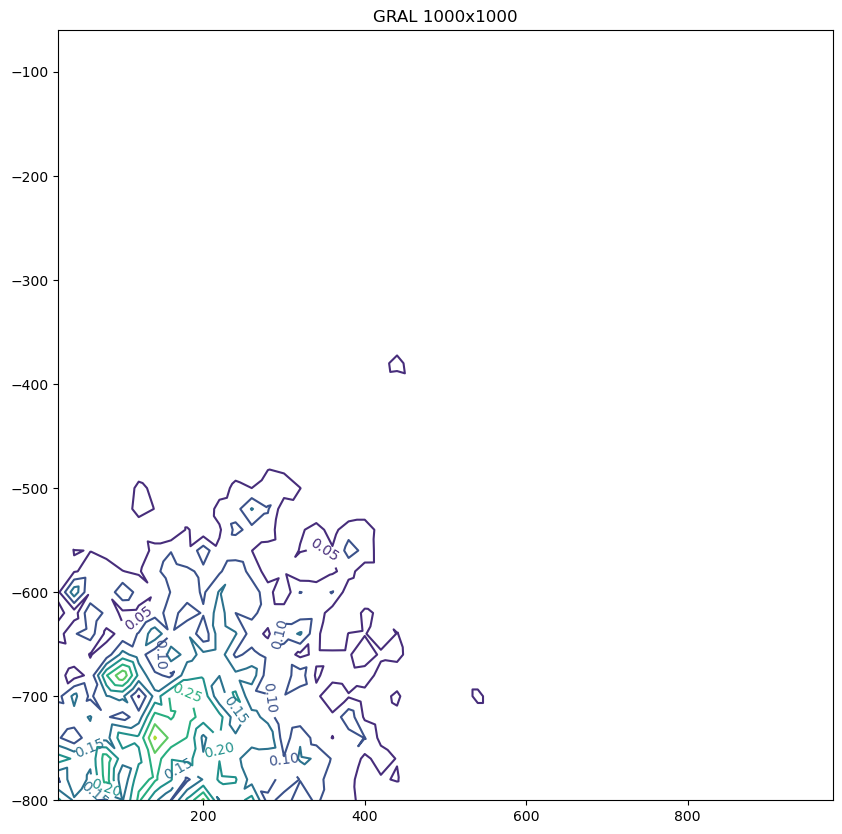

In [317]:
drawGral(1000)